Spam detection using natural language processing based on spam.csv dataset

In [9]:
import numpy as np
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
import itertools
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore') 

In [10]:
spam_dataset = pd.read_csv('spam.csv', encoding="ISO-8859-1")
spam_dataset

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [11]:
spam_dataset = pd.read_csv('spam.csv', encoding="ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'],
                           skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0,1])
spam_dataset

,Spam,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [12]:
#i am checking if classes are balanced
print(spam_dataset['Spam'].value_counts(normalize=True))

Spam
0    0.865937
1    0.134063
Name: proportion, dtype: float64


The most of messages are not spam.

In [13]:
#I am cleaning the text and removing punctuation. 
def remove_puncation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned
spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(lambda x: remove_puncation(x))
spam_dataset

,Spam,Text,Cleaned_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...


In [14]:
#I am tokenizing the text so split it into tokens(words, sentences, subwords).
#Right down below i am removing capital letters(they don't give any important information) and change into small letters.
#The definition i will use also later.

def tokenize(text):

    clean_text = text.lower()
    
    tokenized_text = nltk.word_tokenize(clean_text)
    return tokenized_text

spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(lambda x: tokenize(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,..."
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,..."


In [15]:
#I am removing stopwords(words like "the", "is", "at" etc., no useful information in this case)

stopwords = set(stopwords.words('english'))
def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords]
    return without_stopwords

spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(lambda x: remove_stopwords(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text,WithoutStop_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t..."
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]"
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b..."


In [16]:
#Some of words like "likely", "liked", "likes" has same meaning. I am making stemming and change it into "like".

stemmer = nltk.PorterStemmer()
def stemming(text):
    stemmed_words = [stemmer.stem(word) for word in text]
    return stemmed_words

spam_dataset['Stemmed_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: stemming(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text,WithoutStop_Text,Stemmed_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho..."
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po...","[2nd, time, tri, 2, contact, u, u, å£750, poun..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]","[ì, b, go, esplanad, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]","[piti, mood, soani, suggest]"
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b...","[guy, bitch, act, like, id, interest, buy, som..."


In [17]:
#Lemmatizing is similar to stemming but lemmatizing dont cut part of word.
#For example lemmater for word "better" would be "good".

lemmater = nltk.WordNetLemmatizer()
def lemmatizing(text):
    lemmatized_words = [lemmater.lemmatize(word) for word in text]
    return lemmatized_words

spam_dataset['Lemmatized_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: lemmatizing(x))
spam_dataset

,Spam,Text,Cleaned_Text,Tokenized_Text,WithoutStop_Text,Stemmed_Text,Lemmatized_Text
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho...","[nah, dont, think, go, usf, life, around, though]"
...,...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, å£750, po...","[2nd, time, tri, 2, contact, u, u, å£750, poun...","[2nd, time, tried, 2, contact, u, u, å£750, po..."
5568,0,Will Ì_ b going to esplanade fr home?,Will Ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]","[ì, b, go, esplanad, fr, home]","[ì, b, going, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",Pity was in mood for that Soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]","[piti, mood, soani, suggest]","[pity, mood, soany, suggestion]"
5570,0,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b...","[guy, bitch, act, like, id, interest, buy, som...","[guy, bitching, acted, like, id, interested, b..."


In [18]:
#Based on the lemmatized emails, let's create a string that is a combination of all the words for emails that are spam and emails that are not spam

words_spam = list(spam_dataset.loc[spam_dataset['Spam']==1, 'Lemmatized_Text'].values)
words_spam = list(itertools.chain.from_iterable(words_spam))
words_spam = ' '.join(words_spam)
words_notspam = list(spam_dataset.loc[spam_dataset['Spam']==0, 'Lemmatized_Text'].values)
words_notspam = list(itertools.chain.from_iterable(words_notspam))
words_notspam = ' '.join(words_notspam)

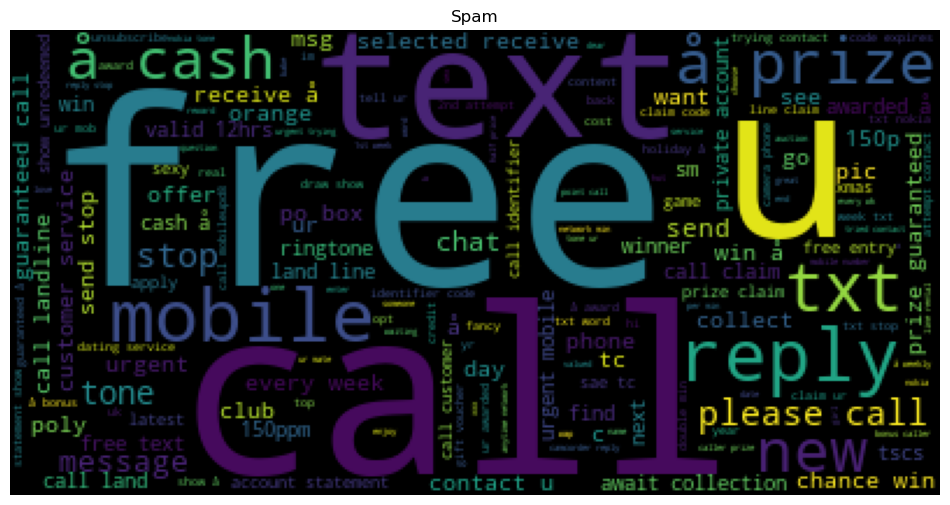

In [19]:
#Word cloud for spam.

wordcloud = WordCloud().generate(words_spam)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Spam')
plt.show()

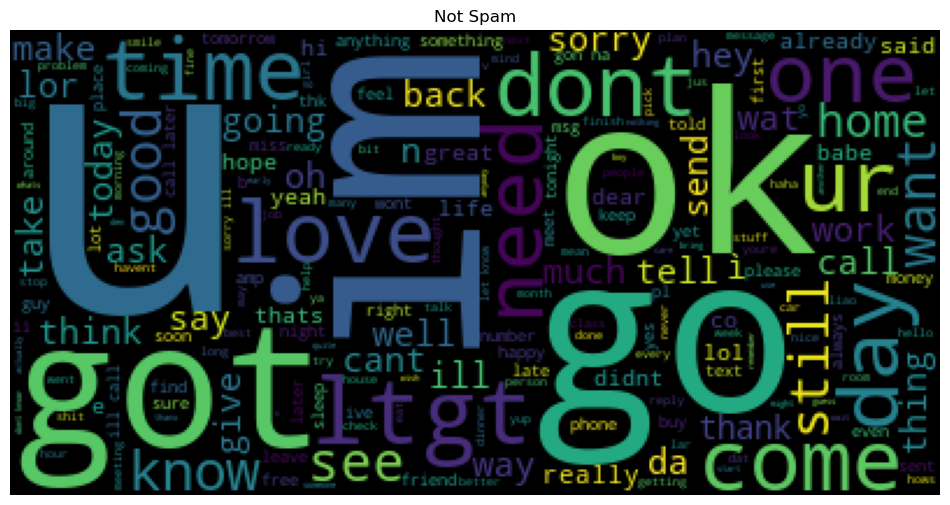

In [20]:
#Word cloud for not spam.

wordcloud = WordCloud().generate(words_notspam)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Not Spam')
plt.show()

Conclusion: The bigger the word the more often appear in text.
In spam emails i can see that word like "reply" appears quite often, this order the recipient to take a certain action.

In [21]:
#I am vectorizing words into numbers.

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x)))

print(X.shape)
y = spam_dataset['Spam']
print(y.shape)

(5572, 8841)
(5572,)


In [22]:
#I am training first model.

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)
clf.score(X, y)

0.8659368269921034

In [23]:
# I will try with another vectorization technique.
#CountVectorizer counts how often each word appears in email. 

count = CountVectorizer(min_df=0.01, max_df=0.5)
X_count = count.fit_transform(spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x)))
X_count

<5572x129 sparse matrix of type '<class 'numpy.int64'>'
	with 15648 stored elements in Compressed Sparse Row format>

In [24]:
#I am training the model.

clf_v2 = RandomForestClassifier(max_depth=2, random_state=0)
clf_v2.fit(X_count, y)
clf_v2.score(X_count, y)

0.8695262024407753

I am not going to compare this two models now. I should divide data into test and train set and choose hyperparameters.

In [25]:
#Now let's see what X looks like, based on which the model learns and performs the prediction. Let's transform it to a Numpy array. 
#Let's show the first 5 observations

print(X_count.toarray()[:5])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0

Here we have 129 variables for each observation, which correspond to individual lemmatized words. The numbers indicate the number of occurrences of words in individual emails (observations). This is a 1-gram model, which means that each word is a separate element for NLP models and there is no interaction between neighboring words. Therefore, n-grams are created, which create new elements based on words that appear next to each other. Perhaps one word has no meaning, but when it occurs in interaction with another word, it may have such meaning.

In [26]:
#TF-IDF improvements
#The same hyperparameters that we used in CountVectorizer can be applied to TfidfVectorizer. 
#Additionally, the TfidfVectorizer transformer takes the frequencies that are returned from CountVectorizer and then transforms these values ​​into values TF-IDF

tfidf = TfidfVectorizer(ngram_range=(2, 2), max_df=0.5, min_df=0.001, use_idf=True)

X = tfidf.fit_transform(spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x)))

In [27]:
# I am dividing data with stratify parameter(it will attempt to keep the same percentages of classes in each split).

X = spam_dataset['Lemmatized_Text'].apply(lambda x: ''.join(x))
y = spam_dataset['Spam']

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, stratify=y, random_state=42)

In [28]:
rf = RandomForestClassifier(max_depth=2, random_state=0)

param_grid = {
    'n_estimators': [50, 100, 200],       
    'max_depth': [10, 20, 30, None],     
    'min_samples_split': [2, 5, 10],     
    'min_samples_leaf': [1, 2, 4],       
    'bootstrap': [True, False],         
}

rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.8659966499162479

In [29]:
#I am making selection and choosing only those with importance higher than 0.001

feature_importances = rf.feature_importances_
important_indices = np.argsort(feature_importances)[::-1][:10]
important_features = [tfidf.get_feature_names_out()[i] for i in important_indices]

print("10 most important features:")
for feature, importance in zip(important_features, feature_importances[important_indices]):
    print(f"{feature}: {importance:.3f}")

10 most important features:
1000cashå: 0.042
pleasecallcustomerservicerepresentativefreephone080814547429am11pmguaranteedå: 0.024
5000awaitcollectioncall09050090044toclaimsaetcpobox334stockportsk38xhcostå: 0.023
urgenttryingcontactutodaydrawshowå: 0.020
wantnewnokia3510icolourphonedeliveredtomorrow300freeminutemobile100freetextfreecamcorderreplycall08000930705: 0.014
spookmobhalloweencollectionlogopicmessageplusfreeeerietonetxtcardspook8007zed08701417012150pperlogopic: 0.014
cameraawardedsipixdigitalcameracall09061221066frommlandlinedeliverywithin28day: 0.014
welldoneenglandgetofficialpolyringtonecolourflagyermobiletexttoneflag84199optouttxtengstopbox39822w111wxå: 0.013
4costadelsolholidayå: 0.013
youvetktseuro2004cupfinalå: 0.012


In [30]:
#I am training RandomForest model using GridSearch.

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_depth=2, random_state=0),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [31]:
print("Best params:", grid_search.best_params_)

Best params: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [32]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

In [33]:
print("\nclassification report:")
print(classification_report(y_test, y_pred))


classification report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1206
           1       1.00      0.33      0.50       187

    accuracy                           0.91      1393
   macro avg       0.95      0.67      0.72      1393
weighted avg       0.92      0.91      0.89      1393



In [34]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9102656137832017


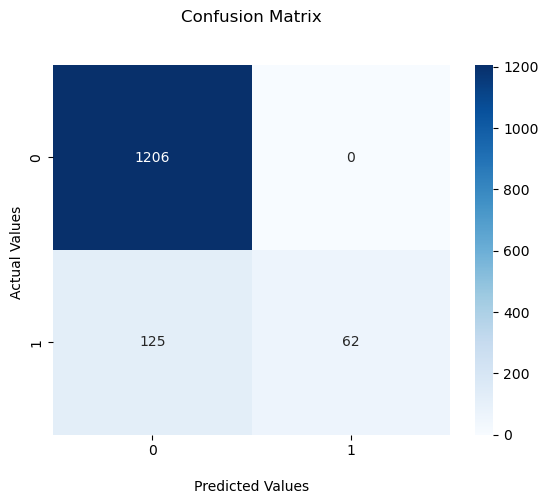

In [35]:
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

The model is excellent at classifying class 0. Oout of 187 examples of class 1, only 62 were classified as . T
the model confuses class 1 with d
despite the high accuracy of 91%, the model has a problem with class balanc. F1 score shows the problem better with score 50 for class 1.ing

Below i will make sentiment analysis.

In [38]:
#Hyperparameters definition

num_words = 5000 #the amount of words
maxlen = 200 #max length of text
embedding_dim = 16 #size of embedding vector
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = num_words)
str(x_train[0])

'[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]'

The imdb.load_data function returns training sets, test sets, and classifications of text data as negative or positive. This is already transformed so that the neural network can use it. In order for us to see what an actual IMDB user comment looks like, we need to convert it back to text.

In [39]:
def vector_to_text(imdb_vector, label):
    reverse_index = {v:k for k, v in imdb.get_word_index().items()}
    return f"""Comment: {" ".join([reverse_index.get(i-3, "#") for i in imdb_vector])}
            Label: {"positive" if label == 1 else "negative"}"""

In [40]:
vector_to_text(x_train[0], y_train[0]), vector_to_text(x_train[1], y_train[1]) , vector_to_text(x_train[2], y_train[2])

("Comment: # this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert # is an amazing actor and now the same being director # father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for # and would recommend it to everyone to watch and the fly # was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also # to the two little # that played the # of norman and paul they were just brilliant children are often left out of the # list i think because the stars that play them all grown up are such a big # for the whole film but these children are amazing and should be # for what they have done don't you think the whol

In [41]:
#We padding comments so that they all have the same length.

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [42]:
#We create a neural network model with one hidden layer with 16 nodes (this is our embedding size)

def build_keras_model(input_dim, output_dim):
    model = Sequential()
    model.add(Embedding(input_dim = input_dim, output_dim = output_dim, embeddings_regularizer=l2(0.01)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
model = build_keras_model(num_words, embedding_dim)

In [43]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5533 - loss: 0.8498 - val_accuracy: 0.6960 - val_loss: 0.6397
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7471 - loss: 0.6063 - val_accuracy: 0.7917 - val_loss: 0.5517
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8127 - loss: 0.5306 - val_accuracy: 0.8238 - val_loss: 0.5043
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8352 - loss: 0.4965 - val_accuracy: 0.8417 - val_loss: 0.4786
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8441 - loss: 0.4685 - val_accuracy: 0.8124 - val_loss: 0.4946
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8445 - loss: 0.4589 - val_accuracy: 0.8509 - val_loss: 0.4512
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8552 - loss: 0.4424 - val_accuracy: 0.8529 - val_loss: 0.4442
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8633 - loss: 0.4287 - val_accuracy: 0.

In [44]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 16)             │          80,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           3,201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 249,605 (975.02 KB)

 Trainable params: 83,201 (325.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 166,404 (650.02 KB)

In [45]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

    Negative       0.90      0.79      0.84     12500
    Positive       0.81      0.91      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.86      0.85      0.85     25000
weighted avg       0.86      0.85      0.85     25000



When evaluating both positive and negative comments, the model is correct about 85% of the time.

In [47]:
def encode_text(text):
    import re 
    def get_word_index(word): 
        w_idx = index.get(word, -1)
        return w_idx + 3 if w_idx <= num_words else 2
    index = imdb.get_word_index()
    text = re.sub(r'[^a-z ]', '', text.lower()) 
    encoded = [get_word_index(word) for word in text.split(" ")] 
    return pad_sequences([[1] + list(encoded)], maxlen=maxlen) 

In [48]:
#let's test how our trained model performs on comments that we provide to it ourselves.
#The following encode_text method will encode the text into a vector for us

encoded_text = encode_text("I love you")
print(encoded_text)
prediction = model.predict(encoded_text)
print(f'Comment is {"Positive" if prediction > 0.5 else "Negative"}. Score: {prediction}')

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1  13
  119  25]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Comment is Positive. Score: [[0.76292825]]
